In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing,
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from datetime import datetime, date

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
items_cat = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
train = pd.read_csv("sales_train.csv")
test = pd.read_csv("test.csv")
shop = pd.read_csv("shops.csv")
submission = pd.read_csv("sample_submission.csv")

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [6]:
train.count()

date              2935849
date_block_num    2935849
shop_id           2935849
item_id           2935849
item_price        2935849
item_cnt_day      2935849
dtype: int64

In [7]:
test.count()

ID         214200
shop_id    214200
item_id    214200
dtype: int64

In [8]:
#First we will check if all shop and items in the test set is also in the training set.
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

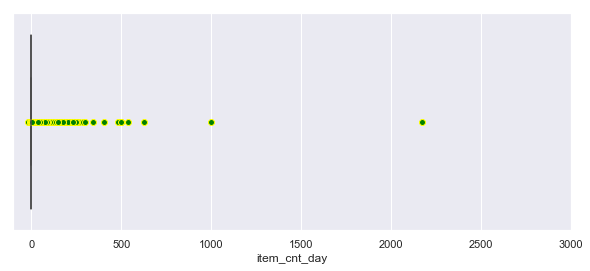

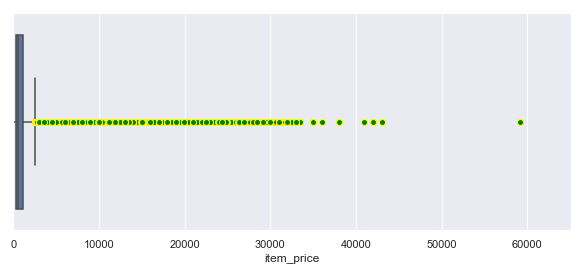

In [10]:
#Negative item _price and count means that item has been returned to the shop that particular day
#removing outliers
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none', markeredgecolor='yellow')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [11]:
# So we can clearly see two outliers ,we can remove them to help the model to obtain best fit
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

In [12]:
train.count()

date              1224437
date_block_num    1224437
shop_id           1224437
item_id           1224437
item_price        1224437
item_cnt_day      1224437
dtype: int64

In [13]:
#So for item_price<0 && item_count<1 ,we are removing those rows
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

In [14]:
train.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2574,399.0,2.0
2,05.01.2013,0,25,2574,399.0,1.0
3,07.01.2013,0,25,2574,399.0,1.0
4,08.01.2013,0,25,2574,399.0,2.0


In [15]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())

In [16]:
grouped

,shop_id,date_block_num,item_cnt_day
0,2,0,250.0
1,2,1,136.0
2,2,2,237.0
3,2,3,169.0
4,2,4,159.0
5,2,5,255.0
6,2,6,243.0
7,2,7,258.0
8,2,8,403.0
9,2,9,347.0


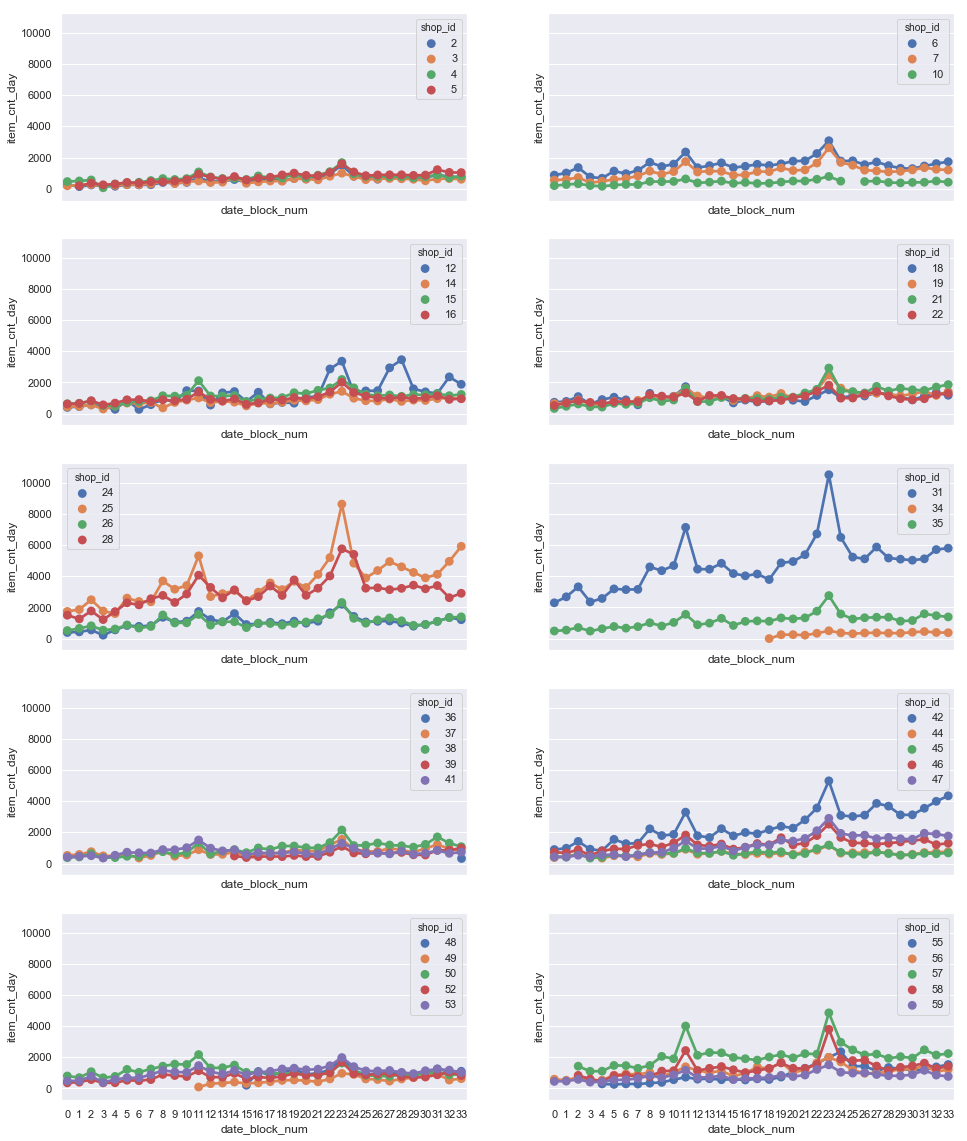

In [17]:
from math import ceil

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

In [19]:
gp = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})

In [20]:
gp

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              2       33               1.0
                       482              1.0
                       491              1.0
                       839              1.0
                       1007             3.0
                       1010             1.0
                       1023             2.0
                       1204             1.0
                       1224             1.0
                       1247             1.0
                       1409             1.0
                       1467             1.0
                       1523             6.0
                       1829             4.0
                       1905             3.0
                       1916             3.0
                       2252             1.0
                       2308             3.0
                       2416             1.0
                       2678             1.0
                       2808            17.0
                       2939             2.0
                       2946             2.0
                       3007             6.0
                       3076             1.0
                       3077             1.0
                       3141             1.0
                       3146             2.0
                       3158             5.0
                       3159             2.0
...                                     ...
33             59      19688            1.0
                       19797            1.0
                       19894            1.0
                       19985            1.0
                       20303            1.0
                       20305            1.0
                       20335            1.0
                       20355            1.0
                       20604            2.0
                       20614            1.0
                       20629            1.0
                       20730            1.0
                       20751            1.0
                       20866            4.0
                       20949           19.0
                       21361            1.0
                       21364            1.0
                       21369            2.0
                       21377            1.0
                       21386            1.0
                       21404            2.0
                       21427            1.0
                       21449            2.0
                       21811            1.0
                       21812            1.0
                       22087            6.0
                       22088            2.0
                       22091            1.0
                       22100            1.0
                       22102            1.0

[600158 rows x 1 columns]

In [21]:
X = np.array(list(map(list, gp.index.values)))
Y = gp.values

In [22]:
X.shape

(600158, 3)

In [23]:
print(X)

[[    0     2    33]
 [    0     2   482]
 [    0     2   491]
 ...
 [   33    59 22091]
 [   33    59 22100]
 [   33    59 22102]]


In [24]:
Y.shape

(600158, 1)

In [25]:
print(Y)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [26]:
test['date_block_num'] = train['date_block_num'].max() + 1
X_test = test[['date_block_num', 'shop_id', 'item_id']].values

In [28]:
X_test

array([[   34,     5,  5037],
       [   34,     5,  5320],
       [   34,     5,  5233],
       ...,
       [   34,    45, 15757],
       [   34,    45, 19648],
       [   34,    45,   969]], dtype=int64)

In [30]:
X_test.shape

(214200, 3)

In [32]:
reg = LinearRegression()

In [33]:
reg.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [34]:
y_test = reg.predict(X_test)

In [35]:
rmse_reg = np.sqrt(mean_squared_error(Y, reg.predict(X)))
print('LR RMSE: %.4f' % rmse_reg)

LR RMSE: 10.8284


In [36]:
submission['item_cnt_month'] = y_test

In [37]:
submission.to_csv('submission.csv', index=False)